<b>Name: Aishwarya Bhavsar<b><br>
<b>CSULB_ID : 029371509<b><br>
CECS 551 - Assignment 5

<b>Relevance Of Deep Learning For Small Data Problems</b>



1. Convnets learn local, translation-invariant features, they’re highly data efficient on perceptual problems.<br> 
2.Training a convnet from scratch on a very small image dataset will still yield reasonable results despite a relative lack of data, without the need for any custom
feature engineering.<br>
3. Deep-learning models are highly repurposable: for example: an image-classification or speech-to-text model trained on a large-scale dataset can be reused on a significantly different problem with only minor changes. 



The 2,000 images used in the assignment are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, I used a subset of the full dataset to decrease training time.

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-03-19 00:16:30--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.128, 142.250.81.208, 142.250.188.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   154MB/s    in 0.4s    

2022-03-19 00:16:30 (154 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `test`,`train` and `validation` subdirectories for the testing,training and validation datasets.<br>
Define each of these directories:

In [4]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directory with our test cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')

# Directory with our test dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [5]:
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training dog images: 1000


In [6]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

total training cat images: 1000


In [7]:
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total validation dog images: 500


In [8]:
print('total validation cat images:', len(os.listdir(validation_cats_dir)))

total validation cat images: 500


In [9]:
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total test dog images: 500


In [10]:
print('total test cat images:', len(os.listdir(test_cats_dir)))

total test cat images: 500


In [11]:
# Instantiating a small convnet for dogs vs. cats classification
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [13]:
#Configuring the model for training
from tensorflow.keras import optimizers
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


**Data PreProcessing** <br><br>
We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).<br>

Data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) We will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).<br>

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [14]:
 #Using ImageDataGenerator to read images from directories
 from keras.preprocessing.image import ImageDataGenerator

In [15]:
#Rescales all images by 1/255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')

Found 2000 images belonging to 2 classes.


In [17]:
validation_generator = train_datagen.flow_from_directory(
validation_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')

Found 1000 images belonging to 2 classes.


In [18]:
 for data_batch, labels_batch in train_generator:
   print('data batch shape:', data_batch.shape)
   print('labels batch shape:', labels_batch.shape)
   break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [19]:
# Fitting the model using a batch generator
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=30,
validation_data=validation_generator,
validation_steps=50)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


100/100 [==============================] - 21s 89ms/step - loss: 0.6875 - acc: 0.5400 - val_loss: 0.6659 - val_acc: 0.5930
Epoch 2/30
100/100 [==============================] - 9s 87ms/step - loss: 0.6483 - acc: 0.6300 - val_loss: 0.6298 - val_acc: 0.6800
Epoch 3/30
100/100 [==============================] - 9s 88ms/step - loss: 0.6016 - acc: 0.6740 - val_loss: 0.5960 - val_acc: 0.6820
Epoch 4/30
100/100 [==============================] - 9s 87ms/step - loss: 0.5591 - acc: 0.7140 - val_loss: 0.5889 - val_acc: 0.6830
Epoch 5/30
100/100 [==============================] - 9s 87ms/step - loss: 0.5226 - acc: 0.7445 - val_loss: 0.5896 - val_acc: 0.6840
Epoch 6/30
100/100 [==============================] - 9s 87ms/step - loss: 0.4980 - acc: 0.7615 - val_loss: 0.5733 - val_acc: 0.7020
Epoch 7/30
100/100 [==============================] - 9s 88ms/step - loss: 0.4613 - acc: 0.7850 - val_loss: 0.5668 - val_acc: 0.7090
Epoch 8/30
100/100 [==============================] - 9s 87ms/step - loss: 0.43

In [20]:
# Saving the model
model.save('cats_and_dogs_small_1.h5')

In [21]:
#plot the loss and accuracy of the model over the training and validation data during training
#Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [22]:
epochs = range(1, len(acc) + 1)

<Figure size 432x288 with 0 Axes>

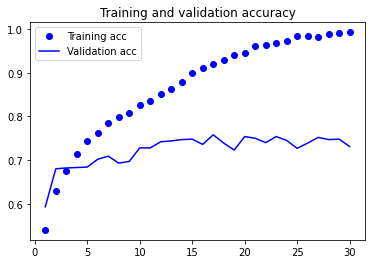

<Figure size 432x288 with 0 Axes>

In [23]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

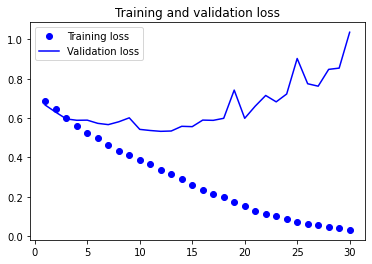

In [24]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Data Augmentation**<br>

To reduce the risk of overfitting.

In [25]:
 #Setting up a data augmentation configuration via ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,
fill_mode='nearest')

In [26]:
#Displaying some randomly augmented training images
#Module with imagepreprocessing utilities
from keras.preprocessing import image

In [27]:
fnames = [os.path.join(train_cats_dir, fname) for
  fname in os.listdir(train_cats_dir)]

In [28]:
#Chooses one image to augment
img_path = fnames[3]

In [29]:
#Reads the image and resizes it
img = image.load_img(img_path, target_size=(150, 150))

In [30]:
#Converts it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

In [31]:
#Reshapes it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

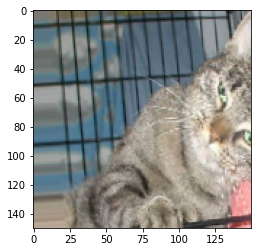

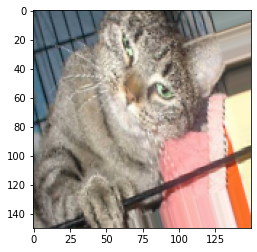

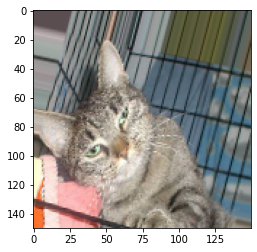

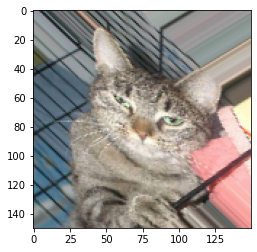

In [32]:
#Generates batches of randomly transformed images. Loops indefinitely, so you need to break the loop at some point!
i=0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 4 == 0:
    break

plt.show()

## Building a Small Convnet from Scratch to Get to 81% Accuracy

The images that will go into our convnet are 150x150 color images (in the next section on Data Preprocessing, we'll add handling to resize all the images to 150x150 before feeding them into the neural network).

Let's code up the architecture. We will stack 4 {convolution + relu + maxpooling} modules. Our convolutions operate on 3x3 windows and our maxpooling layers operate on 2x2 windows. Our first convolution extracts 16 filters, the following one extracts 32 filters, and the last one extracts 128 filters.<br>

Since we have relatively few training examples (1,000), using just three convolutional modules keeps the model small, which lowers the risk of overfitting.

In [33]:
#Defining a new convnet that includes dropout
model = models.Sequential()

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
# First convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window

model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Second convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third convolution extracts 128 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Fourth convolution extracts 128 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
model.add(layers.Flatten())

model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))

#binary classification problem, we will end our network with a sigmoid activation,
#so that the output of our network will be a 
#single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).
model.add(layers.Dense(1, activation='sigmoid'))

#In this case, using the RMSprop optimization algorithm is preferable to stochastic gradient descent (SGD), 
#because RMSprop automates learning-rate tuning for us. 
#(Other optimizers, such as Adam and Adagrad, also automatically adapt the learning rate during training,
#and would work equally well here.)

model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [34]:
# Training the convnet using data-augmentation generators
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,)

In [35]:
#Note that the validation data shouldn’t be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [36]:
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150, 150),
batch_size=32,
class_mode='binary')

Found 2000 images belonging to 2 classes.


In [37]:
validation_generator = test_datagen.flow_from_directory(
validation_dir,
target_size=(150, 150),
batch_size=32,
class_mode='binary')

Found 1000 images belonging to 2 classes.


**Training** <br>
Train on all 2,000 images available, for 100 epochs, and validate on all 1,000 validation images. 

In [39]:
history = model.fit(
train_generator,
steps_per_epoch=None,
epochs=100,
validation_data=validation_generator,
validation_steps=50)

Epoch 1/100
63/63 [==============================] - 21s 325ms/step - loss: 0.6813 - acc: 0.5615 - val_loss: 0.6595 - val_acc: 0.6130
Epoch 2/100
63/63 [==============================] - 14s 224ms/step - loss: 0.6761 - acc: 0.5600
Epoch 3/100
63/63 [==============================] - 14s 224ms/step - loss: 0.6691 - acc: 0.5770
Epoch 4/100
63/63 [==============================] - 14s 226ms/step - loss: 0.6612 - acc: 0.5970
Epoch 5/100
63/63 [==============================] - 14s 223ms/step - loss: 0.6540 - acc: 0.6010
Epoch 6/100
63/63 [==============================] - 14s 230ms/step - loss: 0.6382 - acc: 0.6250
Epoch 7/100
63/63 [==============================] - 16s 249ms/step - loss: 0.6306 - acc: 0.6400
Epoch 8/100
63/63 [==============================] - 14s 222ms/step - loss: 0.6152 - acc: 0.6505
Epoch 9/100
63/63 [==============================] - 14s 222ms/step - loss: 0.6175 - acc: 0.6675
Epoch 10/100
63/63 [==============================] - 15s 232ms/step - loss: 0.6066 - acc:

In [40]:
# Saving the model
model.save('cats_and_dogs_small_2.h5')

<b>Evaluating Accuracy and Loss for the Model</b>

Plot the training/validation accuracy and loss as collected during training:

<Figure size 432x288 with 0 Axes>

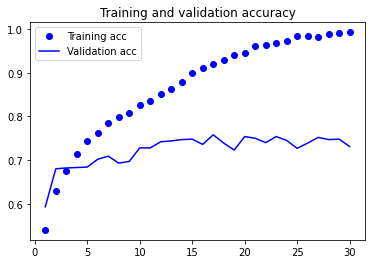

<Figure size 432x288 with 0 Axes>

In [41]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

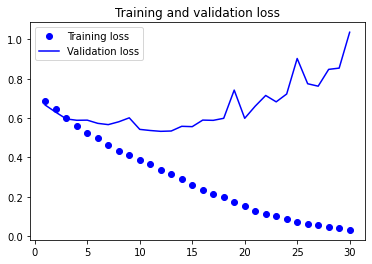

In [42]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<b>Conclusion :</b><br><br>
Earlier before using convnets our model was overfitting. Our training accuracy (in blue dots) gets close to 99% (!) while our validation accuracy (in blue line) stalls as 73.10%. Our validation loss reaches its minimum after only five epochs.

Since we have a relatively small number of training examples (2000), overfitting should be our number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions.

Overfitting is the central problem in machine learning: given that we are fitting the parameters of our model to a given dataset.


